In [2]:
import numpy as np
import os 
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
!ls ../data-preparation/data

data161917112020.pkl  data171917112020.pkl  data-64.pkl  data.pkl


In [4]:
path = '../data-preparation/data'
directory = os.listdir(path)

In [5]:
created_times = list()

for file in directory:
    data_path = os.path.join(path, file)
    created_times.append(os.stat(data_path).st_ctime_ns)

created_times = np.array(created_times)
print(directory)
print(created_times)

most_recent_file = directory[np.argmax(created_times)]

data_path = os.path.join(path, most_recent_file)

['data171917112020.pkl', 'data-64.pkl', 'data161917112020.pkl', 'data.pkl']
[1605647334743204294 1601377686385174792 1605626343897455995
 1601377686297175566]


In [6]:
data_path

'../data-preparation/data/data171917112020.pkl'

In [7]:
with open(data_path, "rb") as f:
    data64 = pickle.load(f)

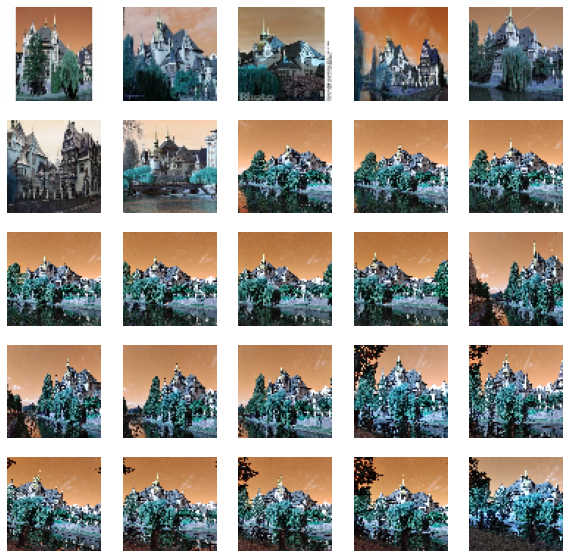

In [8]:
i = np.random.randint(0, data64['images'].shape[0] - 25)

plt.figure(figsize=(10, 10))
for j in range(25):
  plt.subplot(5, 5, j+1)
  plt.imshow(data64['images'][i])
  plt.axis('off')
  i = i + 1
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data64['images'] / 255.,
                                                   data64['y'],
                                                   random_state = 2,
                                                   test_size = .1, 
                                                    stratify=data64['y'])
y_train_cat = to_categorical(y_train, 7)
y_test_cat = to_categorical(y_test, 7)

IndexError: index 11 is out of bounds for axis 1 with size 7

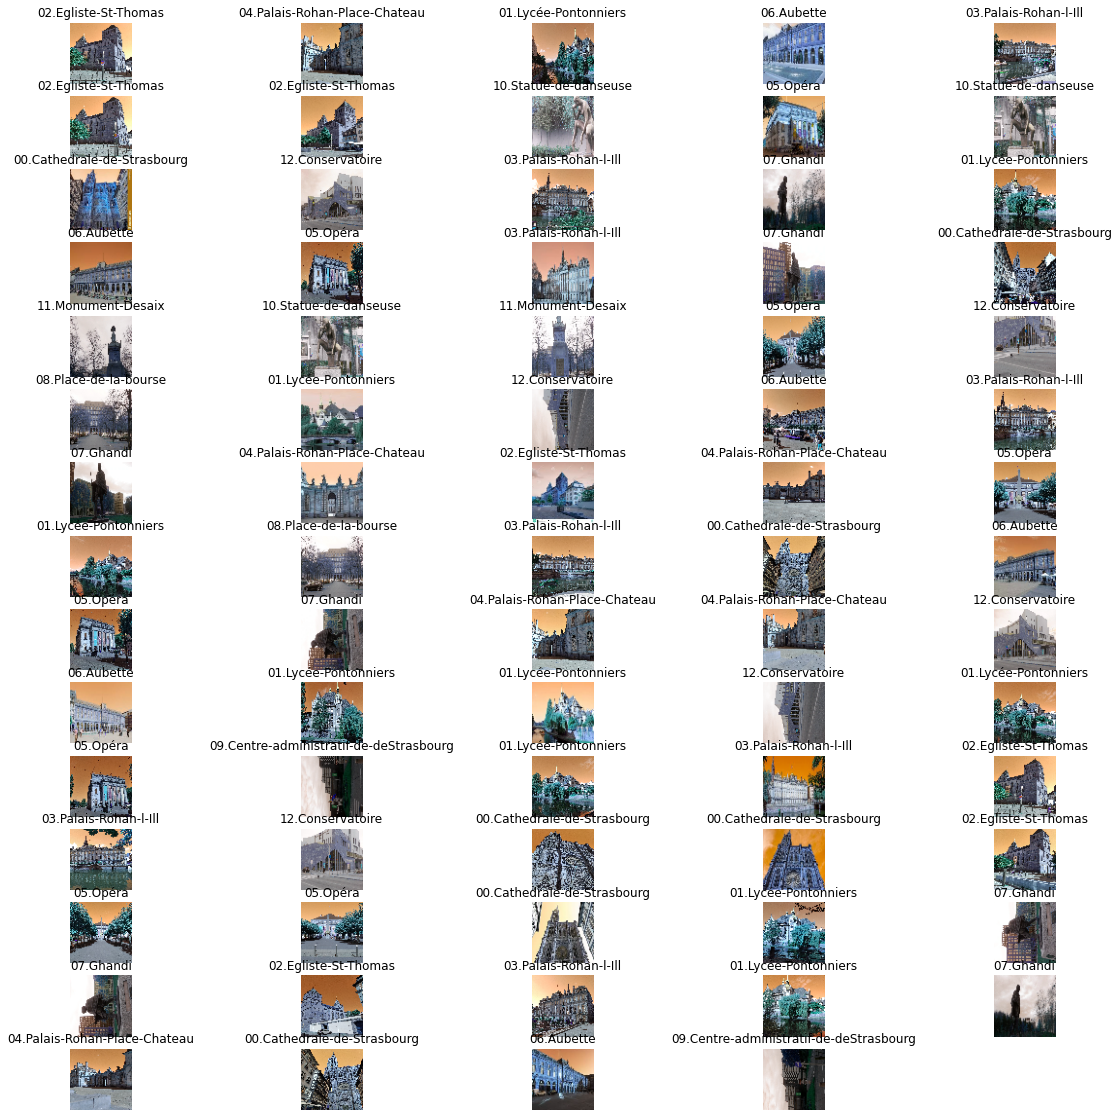

In [11]:
# Check of X_test content

plt.figure(figsize=(20, 20))
for j in range(X_test.shape[0]):
  plt.subplot(int(X_test.shape[0] / 5) + 1, 5, j+1)
  plt.imshow(X_test[j])
  plt.axis('off')
  plt.title(data64['target_names'][y_test[j]])
plt.show()

In [12]:
y_test

array([ 2,  4,  1,  6,  3,  2,  2, 10,  5, 10,  0, 12,  3,  7,  1,  6,  5,
        3,  7,  0, 11, 10, 11,  5, 12,  8,  1, 12,  6,  3,  7,  4,  2,  4,
        5,  1,  8,  3,  0,  6,  5,  7,  4,  4, 12,  6,  1,  1, 12,  1,  5,
        9,  1,  3,  2,  3, 12,  0,  0,  2,  5,  5,  0,  1,  7,  7,  2,  3,
        1,  7,  4,  0,  6,  9])

In [13]:
base_model = VGG16(weights=None, include_top=True, 
             input_shape=X_train.shape[1:],
                  classes=7)

In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [49]:
data_gen = ImageDataGenerator(rotation_range=15, zoom_range=[.8, 1.2], shear_range=5)
data_gen.fit(X_train)

In [50]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
             TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]

In [51]:
x = base_model.get_layer('block3_pool').output
x = Flatten(name='flatten_layer')(x)
x = Dense(512, activation='relu')(x)
x = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

In [52]:
!ls

01-resize-images.ipynb				  04-Model-Utilisation.ipynb
02-Data-Augmentation-and-1st-model-version.ipynb  Draft.ipynb
03-Strasbourg-Pictures.ipynb			  Graph


In [61]:
model.fit(data_gen.flow(X_train, y_train_cat, batch_size=32),
          validation_data=(X_test, y_test_cat), epochs=40,
          steps_per_epoch=len(X_train) / 32, callbacks=callbacks)

Epoch 1/40
15/14 [===============================] - 14s 933ms/step - loss: 0.2822 - accuracy: 0.9091 - val_loss: 0.4906 - val_accuracy: 0.9231
Epoch 2/40
15/14 [===============================] - 14s 917ms/step - loss: 0.1948 - accuracy: 0.9199 - val_loss: 0.5764 - val_accuracy: 0.8846
Epoch 3/40
15/14 [===============================] - 14s 921ms/step - loss: 0.3585 - accuracy: 0.8918 - val_loss: 0.7172 - val_accuracy: 0.7692
Epoch 4/40
15/14 [===============================] - 14s 920ms/step - loss: 0.2808 - accuracy: 0.9026 - val_loss: 0.4551 - val_accuracy: 0.8846
Epoch 5/40
15/14 [===============================] - 14s 953ms/step - loss: 0.2486 - accuracy: 0.9091 - val_loss: 0.3509 - val_accuracy: 0.9231
Epoch 6/40
15/14 [===============================] - 14s 925ms/step - loss: 0.1723 - accuracy: 0.9372 - val_loss: 0.3630 - val_accuracy: 0.9038
Epoch 7/40
15/14 [===============================] - 14s 923ms/step - loss: 0.1269 - accuracy: 0.9524 - val_loss: 0.3950 - val_accuracy:

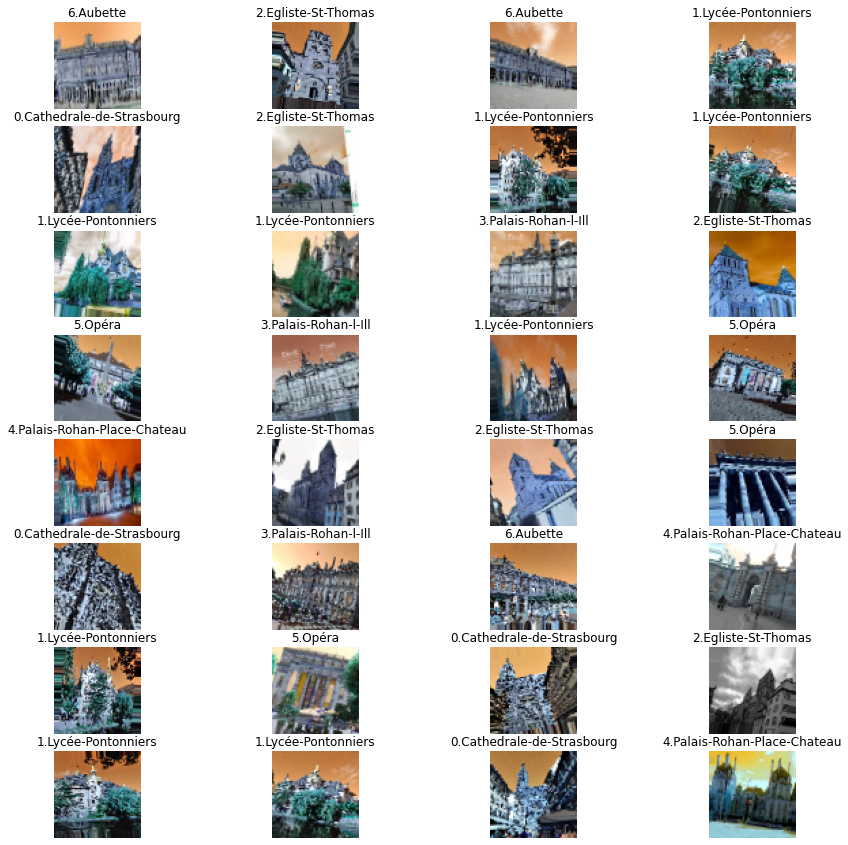

In [32]:
new_images = data_gen.flow(X_train, y_train_cat, batch_size=32)

images, category = next(new_images)

plt.figure(figsize=(15, 15))
for j in range(images.shape[0]):
  plt.subplot(8, 4, j+1)
  plt.imshow(images[j])
  plt.axis('off')
  plt.title(data64['target_names'][np.argmax(category[j])])
plt.show()

In [62]:
pred = list()

for i in range(X_test.shape[0]):
  pred.append(np.argmax(model.predict(X_test)[i]))

pred = np.array(pred)

pred

array([5, 4, 1, 6, 1, 5, 6, 3, 4, 2, 4, 1, 6, 0, 1, 6, 4, 3, 3, 3, 4, 5,
       1, 0, 5, 3, 1, 6, 2, 2, 3, 2, 0, 5, 4, 3, 3, 5, 2, 6, 0, 2, 5, 0,
       0, 1, 5, 3, 1, 1, 0, 1])

In [63]:
y_test

array([5, 4, 1, 6, 1, 5, 6, 3, 4, 2, 4, 1, 6, 0, 1, 6, 4, 2, 3, 3, 4, 5,
       1, 0, 5, 3, 1, 6, 2, 2, 3, 2, 0, 5, 4, 3, 3, 5, 2, 6, 0, 2, 5, 0,
       0, 1, 5, 3, 1, 1, 0, 1])

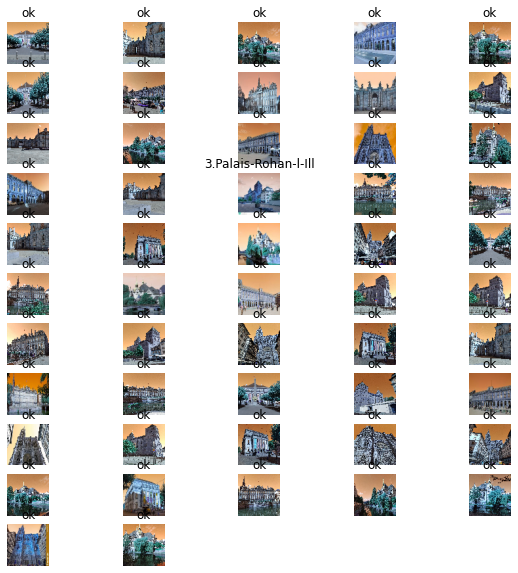

In [65]:
plt.figure(figsize=(10, 10))
for j in range(X_test.shape[0]):
  plt.subplot(int(X_test.shape[0] / 5) + 1, 5, j + 1)
  plt.imshow(X_test[j])
  plt.axis('off')
  if data64['target_names'][pred[j]] == data64['target_names'][y_test[j]]:
    plt.title('ok')
  else:
    plt.title(data64['target_names'][pred[j]])
plt.show()

In [66]:
for j in range(X_test.shape[0]):
  if data64['target_names'][pred[j]] != data64['target_names'][y_test[j]]:
    print(model.predict(X_test)[j] * 100) 

[1.7661301e-03 1.9844801e+01 9.3724146e+00 6.8103745e+01 2.1454673e+00
 2.0922683e-01 3.2258436e-01]


In [75]:
model.predict(X_test)

array([[8.64548807e-19, 5.57174673e-15, 4.01022358e-12, 5.47222833e-19,
        1.15850743e-12, 1.00000000e+00, 1.34354615e-12],
       [5.06822188e-12, 8.35398239e-08, 4.03525028e-03, 8.75987638e-08,
        9.95963454e-01, 5.31968169e-07, 5.96994994e-07],
       [1.16981942e-14, 1.00000000e+00, 2.39939145e-12, 3.21993508e-11,
        2.82916284e-17, 1.01425260e-16, 2.44996112e-08],
       [8.00977275e-03, 4.42854252e-06, 2.05023956e-04, 3.19137238e-04,
        8.09518970e-04, 1.20246895e-02, 9.78627384e-01],
       [5.58081142e-14, 1.00000000e+00, 1.37774805e-14, 3.27028138e-14,
        2.28216749e-17, 8.54002070e-16, 2.96282519e-08],
       [7.75363870e-11, 5.90759810e-05, 2.68725707e-04, 3.89835768e-11,
        1.37268546e-06, 9.99494314e-01, 1.76491478e-04],
       [8.70398289e-05, 4.51771133e-02, 2.36332440e-03, 2.03081663e-03,
        3.78033437e-05, 7.09388260e-05, 9.50232923e-01],
       [2.68814241e-04, 2.16131026e-04, 1.60281256e-01, 8.19368303e-01,
        3.46703862e-04, 1

In [69]:
from tensorflow.keras.models import save_model

In [70]:
!mkdir ../Models/model_3

mkdir: impossible de créer le répertoire «../Models/model_3»: Le fichier existe


In [71]:
saving_path = os.path.join('..', 'Models', 'model_3')

In [72]:
saving_path

'../Models/model_3'

In [73]:
model.save(saving_path)

INFO:tensorflow:Assets written to: ../Models/model_3/assets


In [74]:
!ls ../Models

model_1  model_2  model_3


In [80]:
from tensorflow.keras.metrics import Accuracy

In [87]:
m = Accuracy()
pred = model.predict(data64['images'])
m.update_state(data64['y'], tf.argmax(pred, axis=1))
m.result().numpy()

0.61478597

In [88]:
from sklearn.metrics import accuracy_score

In [94]:
y_test

array([5, 4, 1, 6, 1, 5, 6, 3, 4, 2, 4, 1, 6, 0, 1, 6, 4, 2, 3, 3, 4, 5,
       1, 0, 5, 3, 1, 6, 2, 2, 3, 2, 0, 5, 4, 3, 3, 5, 2, 6, 0, 2, 5, 0,
       0, 1, 5, 3, 1, 1, 0, 1])

In [109]:
pred = model.predict(data64['images'] / 255.)

accuracy_score(data64['y'], np.array(tf.argmax(pred, axis=1)))

0.9922178988326849

In [97]:
pred = model.predict(X_test)

accuracy_score(y_test, np.array(tf.argmax(pred, axis=1)))

0.9807692307692307

In [98]:
pred = model.predict(X_train)

accuracy_score(y_train, np.array(tf.argmax(pred, axis=1)))

0.9935064935064936

In [100]:
X_train.shape, X_test.shape, data64['images'].shape

((462, 64, 64, 3), (52, 64, 64, 3), (514, 64, 64, 3))

In [108]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

pred = model.predict(X)

accuracy_score(y, np.array(tf.argmax(pred, axis=1)))

0.9922178988326849